<table><tr>
<td> <img src="https://upload.wikimedia.org/wikipedia/fr/thumb/e/e5/Logo_%C3%A9cole_des_ponts_paristech.svg/676px-Logo_%C3%A9cole_des_ponts_paristech.svg.png" width="200"  height="200" hspace="200"/> </td>
<td> <img src="https://pbs.twimg.com/profile_images/1156541928193896448/5ihYIbCQ_200x200.png" width="200" height="200" /> </td>
</tr></table>

<br/>

<h1><center>Session 6 - Unsupervised modeling</center></h1>



<font size="3">This session is divided into **3** parts:
- **Loading data**
- **Clustering**
- **Topic modeling**

In each of these parts, some **guidelines** and **hints** are given for each task. 
Do not hesitate to check the links to documentation to understand the functions you use. 
    
The goal of this session is to **implement different unsupervised models** to **create clusters** among movies and to see **which topics emerge** from movies description.
</font>

# 0 - Useful libraries

In [1]:
import pandas as pd
import numpy as np
import random as rd
import json
from matplotlib import pyplot as plt

# 1. Loading data

In [2]:
# Load dataset for unsupervised modeling
data = pd.read_csv('dataset_unsupervised.csv')

# Load tagline data
with open('movies_tagline.json', 'r') as f:
    tagline = json.load(f)
df_tagline = pd.DataFrame.from_dict(tagline, orient='index', columns=['tagline']).reset_index().rename({'index': 'id'}, axis=1)
df_tagline['id'] = df_tagline['id'].astype(int)

# Load overview data
with open('movies_overview.json', 'r') as f:
    overview = json.load(f)
df_overview = pd.DataFrame.from_dict(overview, orient='index', columns=['overview']).reset_index().rename({'index': 'id'}, axis=1)
df_overview['id'] = df_overview['id'].astype(int)

# Merge datasets
data = data.merge(df_tagline, on='id', how='left').merge(df_overview, on='id', how='left')

# Create dictionary to associate a movie ID to its title (will be used for exploration later)
dict_title = data[['id', 'title']].set_index('id').to_dict()['title']

# Drop variables useless for the modeling part (clustering and topic modeling)
data = data.drop(['release_date', 'title', 'index'], axis=1)

In [3]:
data = data.set_index('id')

In [4]:
data.head()

,year,sales,is_part_of_collection,budget,runtime,original_lang_en,original_lang_es,original_lang_fr,original_lang_it,original_lang_ja,...,rolling_sales_collection,mean_3_popularity,mean_5_popularity,actor_1_sales,actor_2_sales,actor_3_sales,mean_sales_actor,max_sales_actor,tagline,overview
id,,,,,,,,,,,,,,,,,,,,,
2475,2000,139087,0,25000000.0,120.0,0,0,1,0,0,...,0.0,0.489158,0.373572,0.0,0.0,0.0,0.0,0.0,,Comme les Mousquetaires dont elles possèdent l...
2870,2000,66228,0,22000000.0,142.0,1,0,0,0,0,...,0.0,1.404085,1.229533,0.0,0.0,0.0,0.0,0.0,,"New York, été 1977. Alors que la ville connait..."
2706,2000,1463152,0,25000000.0,77.0,0,1,0,0,0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,,
11980,2000,32954,0,25000000.0,116.0,1,0,0,0,0,...,0.0,0.465217,0.346425,0.0,0.0,0.0,0.0,0.0,,"Félicia, dix-sept ans, traverse la mer d'Irlan..."
2480,2000,223564,1,40000000.0,99.0,1,0,0,0,0,...,0.0,2.802817,2.044138,0.0,0.0,0.0,0.0,0.0,Il reprend du service.,Arthur Bishop pensait qu'il avait mis son pass...


# 2. Clustering

In [5]:
# For movie clustering, textual variables are not usefull, let's drop them
data_clustering = data.drop(['overview', 'tagline'], axis=1)

In [6]:
data_clustering.head(2)

,year,sales,is_part_of_collection,budget,runtime,original_lang_en,original_lang_es,original_lang_fr,original_lang_it,original_lang_ja,...,cos_month,nb_movie_collection,rolling_sales_collection,mean_3_popularity,mean_5_popularity,actor_1_sales,actor_2_sales,actor_3_sales,mean_sales_actor,max_sales_actor
id,,,,,,,,,,,,,,,,,,,,,
2475,2000,139087,0,25000000.0,120.0,0,0,1,0,0,...,1.732051,0.0,0.0,0.489158,0.373572,0.0,0.0,0.0,0.0,0.0
2870,2000,66228,0,22000000.0,142.0,1,0,0,0,0,...,1.732051,0.0,0.0,1.404085,1.229533,0.0,0.0,0.0,0.0,0.0


In [7]:
# Normalize data
from sklearn.preprocessing import StandardScaler

cols_to_normalize = ['sales', 'budget', 'year', 'runtime', 'holidays', 'cos_month', 'nb_movie_collection', 'rolling_sales_collection',
                     'mean_3_popularity', 'mean_5_popularity', 'actor_1_sales', 'actor_2_sales', 'actor_3_sales', 'mean_sales_actor',
                     'max_sales_actor']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_clustering[cols_to_normalize]) 
data_clustering[cols_to_normalize] = pd.DataFrame(scaled_data)
data_clustering = data_clustering.fillna(0)

In [8]:
data_clustering.head(2)

,year,sales,is_part_of_collection,budget,runtime,original_lang_en,original_lang_es,original_lang_fr,original_lang_it,original_lang_ja,...,cos_month,nb_movie_collection,rolling_sales_collection,mean_3_popularity,mean_5_popularity,actor_1_sales,actor_2_sales,actor_3_sales,mean_sales_actor,max_sales_actor
id,,,,,,,,,,,,,,,,,,,,,
2475,-0.415636,0.119701,0,-0.231311,-0.28000,0,0,1,0,0,...,-0.760779,-0.296292,-0.178509,-0.754163,-0.617331,0.139729,0.209824,1.989242,0.954372,0.818345
2870,-0.242612,0.915479,0,2.534904,1.27308,1,0,0,0,0,...,0.668228,5.599524,10.485622,1.262001,1.818067,3.550578,3.102506,0.173101,3.193107,2.718632


In [9]:
# Split the dataset into a train part and a test part (with a ratio 80/20 for example)
# Hint: take a look at the train_test_split() function from sklearn 
# (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data_clustering, test_size = 0.2)

## 2.1. K-means

In [10]:
from sklearn.cluster import KMeans

In [11]:
X_test_kmeans = X_test.copy()

In [12]:
# Choose a number k of clusters 
k = 10

In [13]:
# Initialize a K-means model
km = KMeans(n_clusters = k, random_state = 0)

In [14]:
# Fit the K-means model to your data
km = km.fit(X_train)

In [15]:
# Predict on your test set
predictions = km.predict(X_test_kmeans)

In [16]:
# Explore your results
# Hint: merge your predictions with your initial dataset X_test_kmeans and use the dict_title object to retrieve which title is associated to
# each movie ID. From there you will be able to know which movies are in each cluster
X_test_kmeans['id'] = X_test_kmeans.index.astype(int)
X_test_kmeans['prediction'] = predictions
X_test_kmeans['title'] = X_test_kmeans['id'].map(dict_title)

In [17]:
# Print the first 10 movies (identified with their titles) associated to a each cluster
# Hint: use a for loop on the number of clusters and use .loc to find movies that are related to the given cluster
for nb in set(X_test_kmeans['prediction']):
    print('Cluster: ', nb)
    print('Number of movies in cluster: ', len(X_test_kmeans.loc[X_test_kmeans['prediction'] == nb]['title']))
    print('Titles: ', X_test_kmeans.loc[X_test_kmeans['prediction'] == nb]['title'][:10])
    print('----- ')

Cluster:  0
Number of movies in cluster:  17
Titles:  id
386                                  Deja Vu
1182                         Cause toujours!
2753                              Double jeu
2003                              Barbershop
1057                         L'Enquête corse
2170    Dieu est grand, je suis toute petite
1892                                  Spider
554                         A Scanner Darkly
544                  Toi et moi... et Dupree
397                        Le Grand Meaulnes
Name: title, dtype: object
----- 
Cluster:  1
Number of movies in cluster:  218
Titles:  id
10708                        All About Steve
7335                     Kié la petite peste
10437                    Une nuit à New York
1247     Capitaine Sky et le monde de demain
414                        La Ferme en folie
15766                                   Five
547                              Miss Potter
14374                               Captives
13497                           Match ret

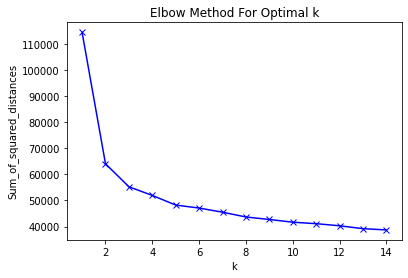

In [18]:
# Try the elbow method to find the optimal number k of clusters. Train a new K-means model with this number, make predictions and explore the
# results
# Hint: use the function plot_elbow() to determine the optimal k

def plot_elbow(X_train, K):
    Sum_of_squared_distances = []
    for k in range(1, K):
        km = KMeans(n_clusters = k, random_state = 0)
        km = km.fit(X_train)
        Sum_of_squared_distances.append(km.inertia_)
    plt.plot(range(1, K), Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    
plot_elbow(X_train, 15)

In [20]:
# Define optimal k and re-train a K-means model
optimal_k = 3
km = KMeans(n_clusters=optimal_k, random_state=0).fit(X_train)

# Make predictions on test set and add corresponding title
X_test_kmeans = X_test.copy()
predictions = km.predict(X_test_kmeans)

# Append predictions and title to the test set
X_test_kmeans['id'] = X_test_kmeans.index.astype(int)
X_test_kmeans['prediction'] = predictions
X_test_kmeans['title'] = X_test_kmeans['id'].map(dict_title)

In [21]:
# Print the first 10 movies associated to a each cluster
for nb in set(X_test_kmeans['prediction']):
    print('Cluster: ', nb)
    print('Number of movies in cluster: ', len(X_test_kmeans.loc[X_test_kmeans['prediction'] == nb]['title']))
    print('Titles: ', X_test_kmeans.loc[X_test_kmeans['prediction'] == nb]['title'][:10])
    print('----- ')

Cluster:  0
Number of movies in cluster:  466
Titles:  id
198                        Il était une fois…
20780    Une nuit au Louvre: Léonard de Vinci
11499                    Un balcon sur la mer
10422                              District 9
2435                    Escrocs mais pas trop
14681                                 Respire
17763                          Chavela Vargas
2332                     Concurrence déloyale
10575                           Louise-Michel
13171                     Ernest et Célestine
Name: title, dtype: object
----- 
Cluster:  1
Number of movies in cluster:  476
Titles:  id
13666                          Rio 2
10708                All About Steve
15165                     Lost River
7335             Kié la petite peste
19002                    Royal Corgi
12219                    L'Etrangère
20154           Histoire d'un regard
10437            Une nuit à New York
12606    Il était une fois, une fois
14132              Les Grandes Ondes
Name: title, dtype: 

# 3. Topic modeling

In [22]:
import wordcloud
from nlpretext import Preprocessor
from nlpretext.basic.preprocess import (
    fix_bad_unicode, lower_text, remove_eol_characters, remove_accents, remove_punct, remove_stopwords,
    normalize_whitespace
)

In [23]:
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz
#!pip install https://github.com/explosion/spacy-models/releases/download/fr_core_news_sm-2.3.0/fr_core_news_sm-2.3.0.tar.gz

In [28]:
# Reset ID as a feature and create regular index for data (from 0 to length of data)
data['id'] = data.index.astype(int)
data.index = range(len(data))

In [24]:
custom_stopwords = ['vie', 'ans', 'jeune', 'film', 'femme', 'homme', 'famille', 'pere', 'fille', 'mere', 'monde',
                    'jour', 'ete']

def preprocess(df_text, custom_stopwords=custom_stopwords):
    df_text = df_text.loc[df_text['text'] != ' ']
    df_text['text_prepro'] = df_text['text'].map(fix_bad_unicode)
    df_text['text_prepro'] = df_text['text_prepro'].map(lower_text)
    df_text['text_prepro'] = df_text['text_prepro'].map(remove_eol_characters)
    df_text['text_prepro'] = df_text['text_prepro'].map(remove_accents)
    df_text['text_prepro'] = df_text['text_prepro'].map(remove_punct)
    df_text['text_prepro'] = df_text['text_prepro'].map(lambda x: remove_stopwords(
        x, lang='fr', custom_stopwords=custom_stopwords))
    df_text['text_prepro'] = df_text['text_prepro'].map(normalize_whitespace)
    df_text['tokens'] = df_text['text_prepro'].map(lambda x: x.split())
    return df_text


def make_word_cloud(text_df: pd.DataFrame):
    """
    Function that computes word cloud from tokens

    Parameters
    ----------
    text_df: pd.DataFrame
        dataframe with text column
    cmp: matplotlib.colors.LinearSegmentedColormap
        colormap for the wordcloud
    """
    text = ' '.join([' '.join(el) for el in text_df['tokens']])
    if isinstance(text, str):
        wordcloud_ = wordcloud.WordCloud(background_color='white', width=700, height=500).generate(text)
    else:
        raise TypeError('text_df contains non str values')
    plt.imshow(wordcloud_)
    plt.axis("off")
    plt.show()

In [25]:
# Create a 'text' column that is a combination of the tagline and the overview
# Example:
# - tagline = 'Il reprend du service.'
# - overview = 'Arthur Bishop pensait qu'il avait mis son passé de tueur à gages derrière lui. ... etc'
# -> text = 'Il reprend du service. Arthur Bishop pensait qu'il avait mis son passé de tueur à gages derrière lui. ... etc'
data['text'] = data['tagline'] + ' ' + data['overview']

In [29]:
# Explore the results of the preprocessing
# Feel free to change the value of 'i' to see several examples
i = 0

preprocessed_text = preprocess(pd.DataFrame(data.iloc[i]).T)
print('Raw text:', data['text'][i])
print()
print('Preprocessed text:', preprocessed_text['text_prepro'][i])
print()
print('Preprocessed tokens:', preprocessed_text['tokens'][i])

Raw text:  Comme les Mousquetaires dont elles possèdent le cran, l’âme festive et le sens de l’amitié… Ces battantes vivent à Paris et, au premier jour de l’an 2000, elles remettent à l’heure les pendules de leurs vies.  A 35 ans, elles ne croient plus au prince charmant. Leurs carrières théâtrales battent de l’aile et leurs maigres porte-feuilles ne tiennent peut-être qu’à une larme ou un sourire.

Preprocessed text: mousquetaires possedent cran ame festive sens amitie battantes vivent paris an 2000 remettent heure pendules vies 35 croient prince charmant carrieres theatrales battent aile maigres porte feuilles tiennent larme sourire

Preprocessed tokens: ['mousquetaires', 'possedent', 'cran', 'ame', 'festive', 'sens', 'amitie', 'battantes', 'vivent', 'paris', 'an', '2000', 'remettent', 'heure', 'pendules', 'vies', '35', 'croient', 'prince', 'charmant', 'carrieres', 'theatrales', 'battent', 'aile', 'maigres', 'porte', 'feuilles', 'tiennent', 'larme', 'sourire']


In [30]:
# Preprocess the 'text' column:
# - transform the text to lowercase
# - remove end of line characters
# - remove accents
# - remove punctuation
# - remove stopwords
# - split the preprocessed text into words (i.e. tokens) and store it into a new column named 'tokens'

import warnings
warnings.filterwarnings('ignore')

data = preprocess(data)

## 3.1 LDA

In [31]:
import gensim
import gensim.corpora as corpora

In [32]:
# Create a list of all tokens associated to each movie and store it into the variable data_words
data_words = data['tokens'].tolist()
print(data_words[:1][0][:10])

['mousquetaires', 'possedent', 'cran', 'ame', 'festive', 'sens', 'amitie', 'battantes', 'vivent', 'paris']


In [33]:
# Create a Dictionary based on the all the words per movie
# Hint: explore the gensim library (specifically the 'corpora' section...)
id2word = corpora.Dictionary(data_words)

In [34]:
# Create a Corpus for each text associated to each movie
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [35]:
# Define a number of topics
num_topics = 7

In [36]:
# Train a LDA model
# Hint: explore the gensim library (specifically the 'models' section...)
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

In [37]:
# Print the keywords in the n topics
# Hint: maybe the gensim LDA model has a built-in function to do so...
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.003*"nouvelle" + 0.003*"grand" + 0.003*"histoire" + 0.003*"rencontre" + '
  '0.003*"petit" + 0.002*"fils" + 0.002*"retrouver" + 0.002*"amour" + '
  '0.002*"aventure" + 0.002*"ville"'),
 (1,
  '0.005*"histoire" + 0.003*"ville" + 0.003*"annees" + 0.003*"fils" + '
  '0.003*"grand" + 0.003*"rencontre" + 0.002*"decide" + 0.002*"petit" + '
  '0.002*"vivre" + 0.002*"guerre"'),
 (2,
  '0.005*"histoire" + 0.004*"amour" + 0.004*"decide" + 0.003*"temps" + '
  '0.003*"jamais" + 0.002*"grand" + 0.002*"retrouve" + 0.002*"petit" + '
  '0.002*"ville" + 0.002*"maison"'),
 (3,
  '0.003*"amis" + 0.003*"enfants" + 0.003*"parents" + 0.003*"histoire" + '
  '0.003*"grand" + 0.002*"petite" + 0.002*"passe" + 0.002*"maison" + '
  '0.002*"trouve" + 0.002*"amour"'),
 (4,
  '0.004*"histoire" + 0.003*"enfants" + 0.003*"decide" + 0.003*"maison" + '
  '0.003*"grand" + 0.003*"nuit" + 0.002*"face" + 0.002*"annees" + '
  '0.002*"petite" + 0.002*"jours"'),
 (5,
  '0.005*"histoire" + 0.003*"fils" + 0.003*"petite

In [38]:
# Visualize the topics
# Hint: use pyLDAvis
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
LDAvis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.016438 -0.023179       1        1  18.366272
0     -0.038787 -0.017102       2        1  15.779683
1     -0.022808 -0.045728       3        1  15.281706
3     -0.008002 -0.004984       4        1  13.316949
4      0.084113 -0.021628       5        1  12.950518
2      0.029673  0.049061       6        1  12.533254
5     -0.027750  0.063560       7        1  11.771626, topic_info=           Term        Freq       Total Category  logprob  loglift
163    histoire  925.000000  925.000000  Default  30.0000  30.0000
340    nouvelle  427.000000  427.000000  Default  29.0000  29.0000
5549        vic   50.000000   50.000000  Default  28.0000  28.0000
17597    sirene   45.000000   45.000000  Default  27.0000  27.0000
2248       alex  159.000000  159.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1179   aventure   47.563419  349.745483   Topic7  -6.4231   0.1443
260       temps   53.578495  502.085419   Topic7  -6.3040  -0.0981
172        part   44.007446  310.894501   Topic7  -6.5008   0.1844
18        paris   44.640671  345.141907   Topic7  -6.4865   0.0942
503      jamais   44.356655  433.008545   Topic7  -6.4929  -0.1390

[641 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
32045      3  0.903345     1849
9273       1  0.124711       20
9273       2  0.138567       20
9273       3  0.041570       20
9273       4  0.055427       20
...      ...       ...      ...
16112      2  0.039027  zombies
16112      3  0.819576  zombies
16112      4  0.039027  zombies
16112      6  0.039027  zombies
32093      2  0.899150  zunaira

[1687 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 2, 4, 5, 3, 6])

In [39]:
# What are your conclusions regarding the topics? (coherence, stability, ...)

## 3.2 To go further on Topic Modeling: Top2Vec

In [40]:
from top2vec import Top2Vec
# Pre-requisites for top2vec: keras_applications, keras_preprocessing

### 3.2.1 Topics interpretation

In [41]:
# Load the trained Top2Vec model
model_bis = Top2Vec.load('top2vec_imdb.pickle')

# Get information about the model: number of topics found and their sizes
n_topics_found = model_bis.get_num_topics()
topic_sizes, topic_nums = model_bis.get_topic_sizes()

print('Number of topics found:', n_topics_found)
print('Topic sizes:')
for n in range(n_topics_found):
    print('Topic ', n, ' - Size: ', topic_sizes[n])
    print(' ----- ')

Number of topics found: 18
Topic sizes:
Topic  0  - Size:  1559
 ----- 
Topic  1  - Size:  1077
 ----- 
Topic  2  - Size:  641
 ----- 
Topic  3  - Size:  449
 ----- 
Topic  4  - Size:  449
 ----- 
Topic  5  - Size:  354
 ----- 
Topic  6  - Size:  247
 ----- 
Topic  7  - Size:  241
 ----- 
Topic  8  - Size:  235
 ----- 
Topic  9  - Size:  235
 ----- 
Topic  10  - Size:  202
 ----- 
Topic  11  - Size:  193
 ----- 
Topic  12  - Size:  189
 ----- 
Topic  13  - Size:  164
 ----- 
Topic  14  - Size:  142
 ----- 
Topic  15  - Size:  126
 ----- 
Topic  16  - Size:  92
 ----- 
Topic  17  - Size:  81
 ----- 


In [42]:
# Explore the results part 1: check the texts with the best scores in each cluster

# Change "nb" between 0 and 17 to explore each cluster
# Clusters are sorted according to the number of texts they contain (exploring clusters between 0 and 10 may be
# enough to have a good overview of what main clusters represent)
nb = 0

# You can also change the number of texts to display for each cluster with 'num_docs'
num_docs = 7

documents, document_scores, document_ids = model_bis.search_documents_by_topic(topic_num = nb, num_docs = num_docs)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print(doc)
    print("-----------")

Document: 196, Score: 0.9136438965797424
 La fine équipe se retrouve pour une folle chasse au trésor afin d'empocher 500 millions de roupies.
-----------
Document: 5093, Score: 0.9112980365753174
Une vraie gueule d'ange Hellboy affronte Nimue, épouse de Merlin et Reine de Sang. Leur lutte amorcera la fin du monde, un sort que le héros devra éviter à tout prix.
-----------
Document: 408, Score: 0.903130054473877
Traîtres ou héros? Début 90. Un groupe de Cubains installés à Miami met en place un réseau d’espionnage. Leur mission : infiltrer les groupuscules anti-castristes responsables d’attentats sur l’île.
-----------
Document: 6635, Score: 0.8978111743927002
 Le légendaire sauveteur Mitch Buchannon est contraint de s’associer à une nouvelle recrue, Matt Brody, aussi ambitieux que tête brûlée ! Ensemble, ils vont tenter de déjouer un complot criminel qui menace l'avenir de la Baie…
-----------
Document: 388, Score: 0.8973255157470703
Dans les profondeurs de l'océan, quelque chose s'est

Topic 0


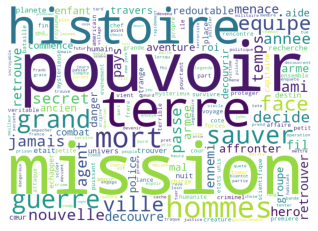

Topic 1


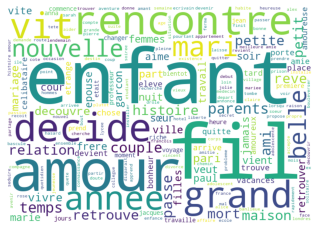

Topic 2


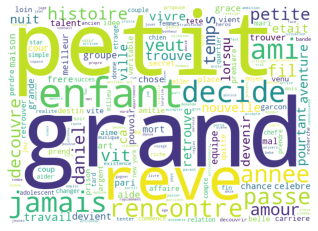

Topic 3


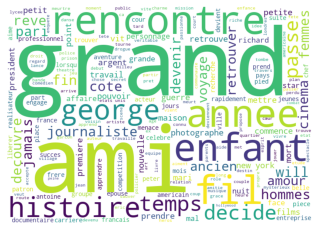

Topic 4


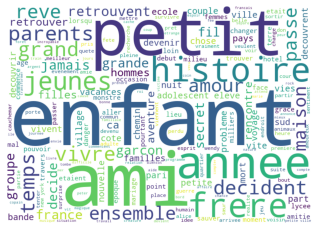

Topic 5


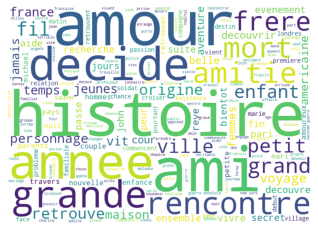

Topic 6


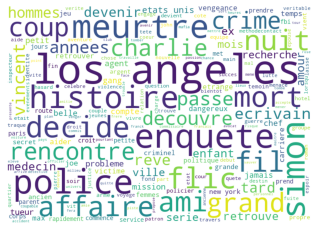

Topic 7


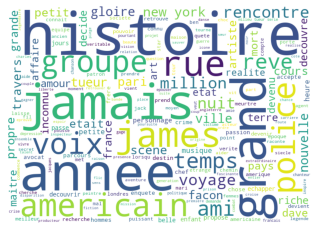

Topic 8


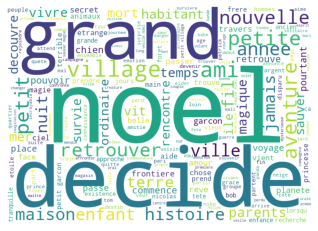

Topic 9


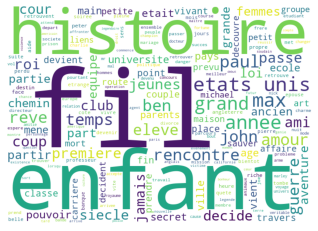

Topic 10


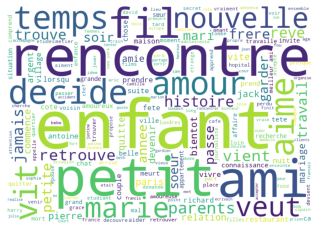

In [43]:
# Explore the results part 2: check the wordclouds associated to each cluster
# Wordclouds are really helpful to have a quick overview of most important words related to each topic
# They can help to interpret each topic

import warnings
warnings.filterwarnings('ignore')

for nb in range(11):
    documents, document_scores, document_ids = model_bis.search_documents_by_topic(topic_num=nb, num_docs=topic_sizes[nb])
    df_text = preprocess(pd.DataFrame(documents, columns=['text']))
    print('Topic', nb)
    make_word_cloud(df_text)

In [44]:
# What would be your interpretation for each cluster ?

# Topic 0: action
# Topic 1: comédie romantique
# Topic 2: drame
# Topic 3: Court-metrage
# Topic 4: histoire de jeunes, duos
# Topic 5: histoire de famille
# Topic 6: flic, los angeles
# Topic 7: histoire, culture
# Topic 8: noël
# Topic 9: aventure
# Topic 10: amour

### 3.2.2 To go further: train your own Top2Vec model

In [45]:
# Create a new dataset for top2vec model, from the 'data' dataframe, do not take movies with empty text 
# into account
data_top2vec = data.loc[(data['text'] != '') & (data['text'].isnull() == False)]

# Make a list from the 'text' column that will contain all texts associated to all movies
all_texts = data_top2vec["text"].tolist()

In [46]:
# Train a top2vec model
model = Top2Vec(documents=all_texts, speed="learn")

2021-03-17 15:28:11,799 - top2vec - INFO - Pre-processing documents for training
2021-03-17 15:28:15,027 - top2vec - INFO - Creating joint document/word embedding
2021-03-17 15:29:14,854 - top2vec - INFO - Creating lower dimension embedding of documents
2021-03-17 15:29:59,707 - top2vec - INFO - Finding dense areas of documents
2021-03-17 15:30:00,213 - top2vec - INFO - Finding topics


In [47]:
# Explore the results:
# - number of topics found
# - topics sizes

n_topics_found = model.get_num_topics()
topic_sizes, topic_nums = model.get_topic_sizes()
print('Number of topics found:', n_topics_found)
print('Topic sizes:')
for n in range(n_topics_found):
    print('Topic ', n, ' - Size: ', topic_sizes[n])
    print(' ----- ')

Number of topics found: 31
Topic sizes:
Topic  0  - Size:  540
 ----- 
Topic  1  - Size:  429
 ----- 
Topic  2  - Size:  425
 ----- 
Topic  3  - Size:  341
 ----- 
Topic  4  - Size:  331
 ----- 
Topic  5  - Size:  301
 ----- 
Topic  6  - Size:  287
 ----- 
Topic  7  - Size:  279
 ----- 
Topic  8  - Size:  262
 ----- 
Topic  9  - Size:  251
 ----- 
Topic  10  - Size:  231
 ----- 
Topic  11  - Size:  223
 ----- 
Topic  12  - Size:  222
 ----- 
Topic  13  - Size:  208
 ----- 
Topic  14  - Size:  207
 ----- 
Topic  15  - Size:  200
 ----- 
Topic  16  - Size:  184
 ----- 
Topic  17  - Size:  166
 ----- 
Topic  18  - Size:  165
 ----- 
Topic  19  - Size:  164
 ----- 
Topic  20  - Size:  158
 ----- 
Topic  21  - Size:  152
 ----- 
Topic  22  - Size:  150
 ----- 
Topic  23  - Size:  112
 ----- 
Topic  24  - Size:  97
 ----- 
Topic  25  - Size:  78
 ----- 
Topic  26  - Size:  65
 ----- 
Topic  27  - Size:  59
 ----- 
Topic  28  - Size:  38
 ----- 
Topic  29  - Size:  36
 ----- 
Topic  30  - Siz

In [48]:
# Save your model for later if you want to explore it in more details
# model.save('top2vec_imdb_bis.pickle')